In [10]:
import numpy as np
import pygimli as pg
#import pybert as pb
from pygimli.physics import ert
#from pybert.importer.exportData import exportRes2dInv
from pygimli.physics.ert.importData import importRes2dInv
import matplotlib.pyplot as plt
import pygimli.meshtools as mt
from pygimli.frameworks import PriorModelling, JointModelling
from scipy.interpolate import interp1d
import pandas as pd
import pickle

In [11]:
dir='//smb.isipd.dmawi.de/projects/p_subaqua/Expeditions/2023/NWT2023/analysis_Tuk/Tuk_all_mehriban/'

In [12]:
data = ert.load('//smb.isipd.dmawi.de/projects/sparc/data/Sensors_Mobile/202307_DEPTHAW_InuvikTuk/IRISSyscalProSwitch/res2Dinv/ERT_data_western_terrestrial_DAT.txt')

In [13]:
data_topo = ert.load('//smb.isipd.dmawi.de/projects/sparc/data/Sensors_Mobile/202307_DEPTHAW_InuvikTuk/IRISSyscalProSwitch/res2Dinv/DAT_all_filters/ERT_data_western_terrestrial_DAT.dat')

10/11/25 - 08:49:05 - pyGIMLi - INFO - could not read unified data format for ERT ... try res2dinv


(<Axes: >, <matplotlib.colorbar.Colorbar at 0x18c7e340210>)

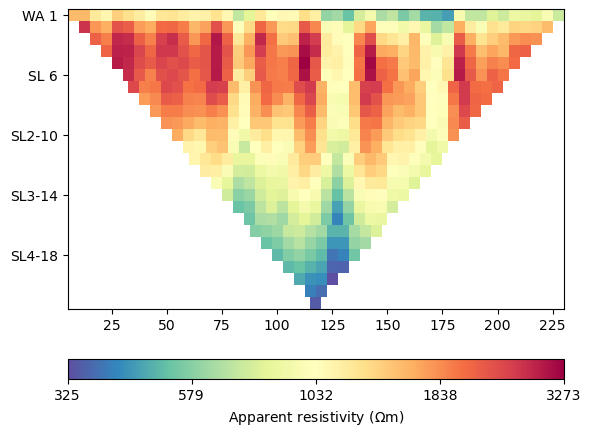

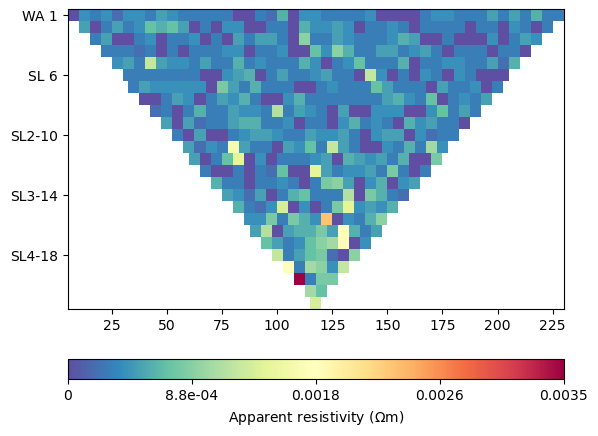

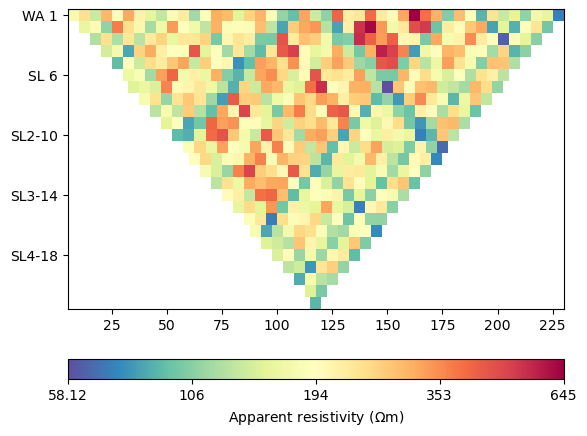

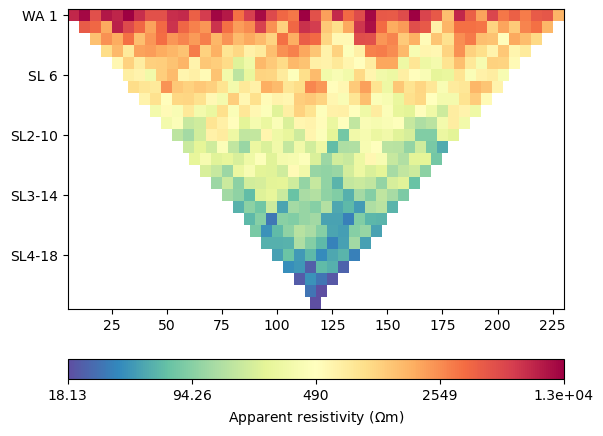

In [14]:
ert.show(data)
ert.show(data, data['err'])
ert.show(data, data['i'])
ert.show(data, data['u'])

(<Axes: >, <matplotlib.colorbar.Colorbar at 0x18c7e9e2550>)

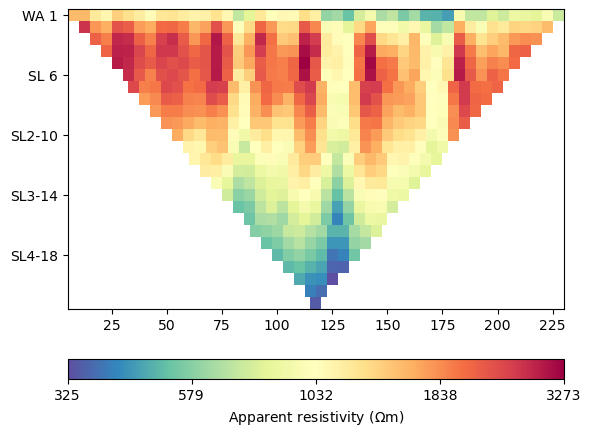

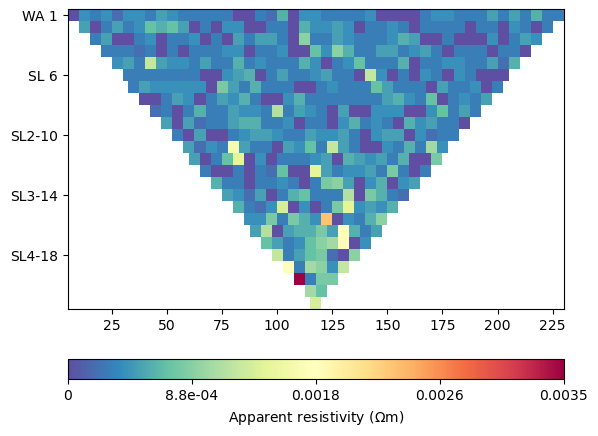

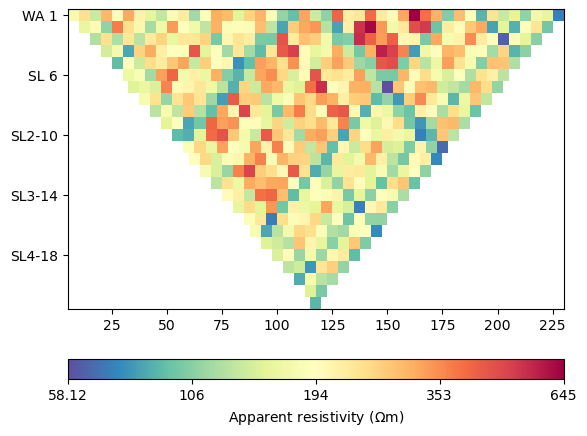

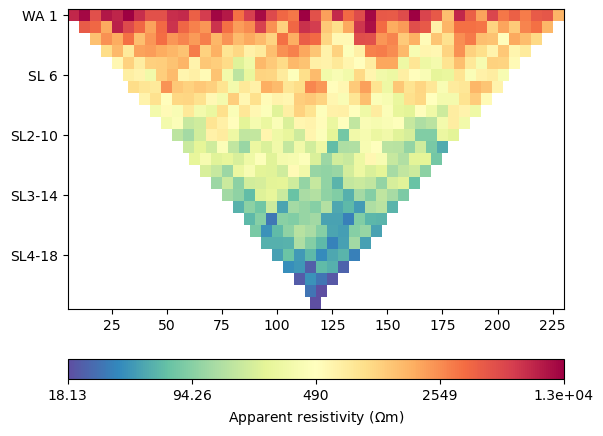

In [15]:
data.remove(data['err']>=0.05)
data.remove(data['i'] < 1)
data.remove(data['rhoa'] <= 0)
ert.show(data)
ert.show(data, data['err'])
ert.show(data, data['i'])
ert.show(data, data['u'])

(<Axes: >, <matplotlib.colorbar.Colorbar at 0x18c2a07f050>)

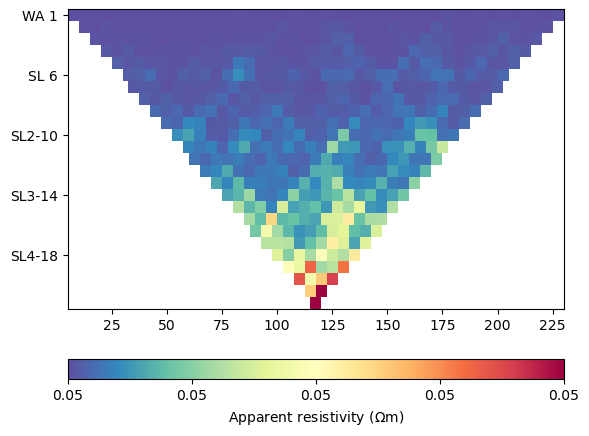

In [16]:
data['err'] = ert.estimateError(data, relativeError=0.05, absoluteUError=5e-4)
ert.show(data, data['err'])

In [17]:
data['k'] = ert.createGeometricFactors(data)
data.setSensorPositions(pg.meshtools.interpolateAlongCurve(data_topo.additionalPoints(), pg.x(data_topo)))
data['k_topo'] = ert.createGeometricFactors(data, numerical=True)

10/11/25 - 08:49:23 - pyGIMLi - INFO - Cache c:\Users\mealiy001\AppData\Local\miniconda3\envs\pgcore\Lib\site-packages\pygimli\physics\ert\ert.py:createGeometricFactors restored (0.0s x 1): C:\Users\mealiy001\AppData\Roaming\pygimli\Cache\9383995667644338398
10/11/25 - 08:49:23 - pyGIMLi - INFO - Create default mesh for geometric factor calculation.
10/11/25 - 08:49:26 - pyGIMLi - INFO - Save RVector binary
10/11/25 - 08:49:26 - pyGIMLi - INFO - Cache stored: C:\Users\mealiy001\AppData\Roaming\pygimli\Cache\13379069263700392511


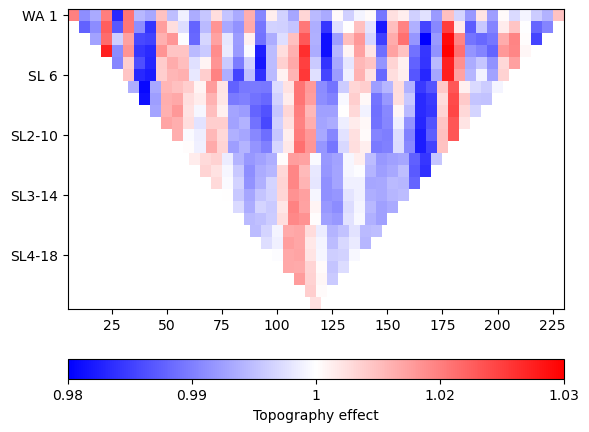

In [18]:
_ = ert.showData(data, vals=data['k_topo']/ data['k'], label='Topography effect',
                 logScale=True, cMap="bwr")

In [19]:
data['rhoa'] = data['r']*data['k_topo']

In [20]:
mgr = ert.ERTManager(data)

In [21]:
np.mean(data['rhoa'])

1430.233410074385

In [22]:
west_p_AL = pd.read_csv(dir+"AL/TOPO_data_western_terrestrial.txt", sep='\s+', skiprows=1)


alt = west_p_AL.to_numpy()

xy = alt
x = xy[:, 0]
y = xy[:, 1] - xy[:, 2]


df_out = pd.DataFrame({"x": x, "y": y})

(<Axes: xlabel='$x$ in m', ylabel='Depth in m'>,
 <matplotlib.colorbar.Colorbar at 0x18c7cc4b410>)

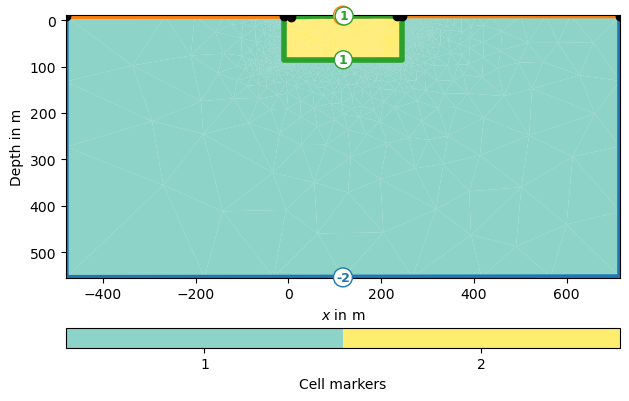

In [24]:
plc = mt.createParaMeshPLC(data, paraDX = 0.25, paraDZ= 0.25, boundary=2, paraMaxCellSize=25)

# Convert DataFrame to polygon
verts = df_out[["x", "y"]].values.tolist()
line = mt.createPolygon(verts, marker=1)

# Add polygon to mesh
plc += line
mesh = mt.createMesh(plc, quality=34.5)
pg.show(mesh, markers=True)

10/11/25 - 08:53:54 - pyGIMLi - INFO - Found 2 regions.
10/11/25 - 08:53:54 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
10/11/25 - 08:53:54 - pyGIMLi - INFO - Creating forward mesh from region infos.
10/11/25 - 08:53:55 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
10/11/25 - 08:53:55 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 29343 Cells: 57792 Boundaries: 43790
10/11/25 - 08:53:56 - pyGIMLi - INFO - Use median(data values)=1304.2215622141784
10/11/25 - 08:53:56 - pyGIMLi - INFO - Created startmodel from forward operator:12304, min/max=1304.221562/1304.221562
10/11/25 - 08:53:56 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x0000018C29FD58F0>
Data transformation: Logarithmic LU transform, lower bound 0.0, upper bound 0.0
Model transformation: Logarithmic transform
min/max (data): 325/3356
min/max (error): 5%/5%
min/max (start model): 1304/1304
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =   99.17
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   67.83 (dPhi = 31.52%) lam: 30.0
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =   41.03 (dPhi = 39.06%) lam: 30.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =   33.41 (dPhi = 18.13%) lam: 30.0
--------------------------------------------------------------------------------
inv.iter 4 ... chi² =   23.41 (dPhi = 28.83%) lam: 30.0
------------------------------------------------------

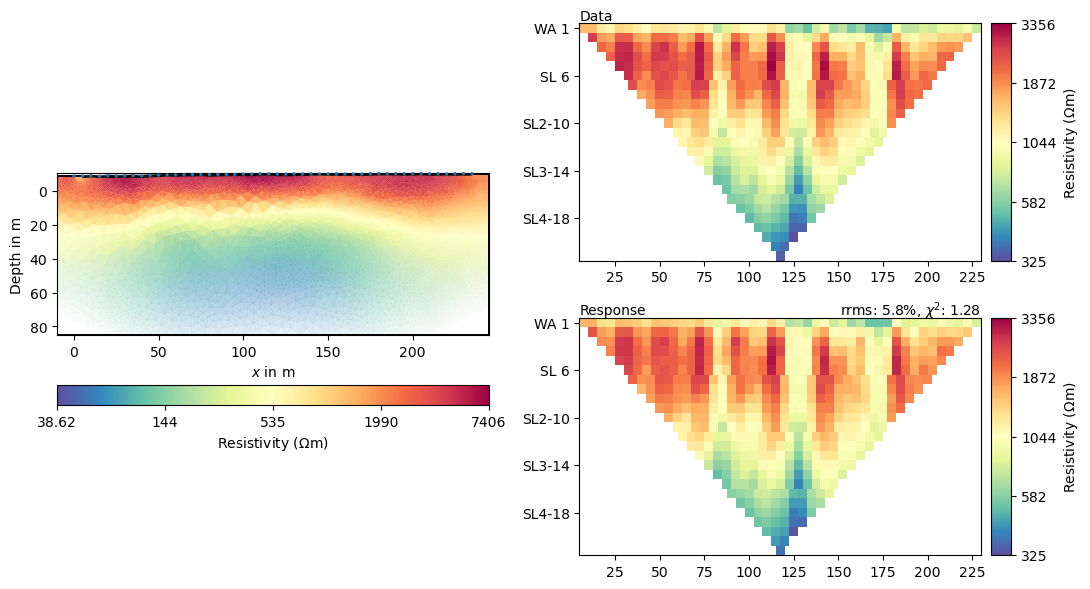

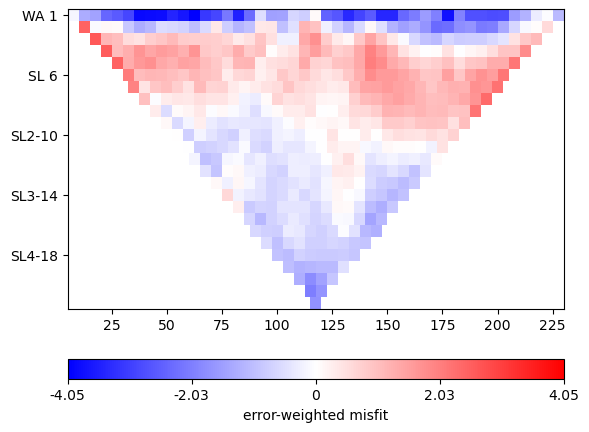

In [25]:
mgr.setMesh(mesh)


inv = mgr.invert(verbose=True, lam=30)


mgr.showResultAndFit()
mgr.showMisfit(errorWeighted=True)

0 -10.0 8.753790871 0.0
1 -10.0 -85.21264893118544 0.0
2 244.91609950546362 -85.21264893118544 0.0
3 244.91609950546362 10.19363932 0.0
4 -949.6643980218545 8.753790871 0.0
5 -949.6643980218545 -1024.8770469530398 0.0
6 1184.5804975273181 10.19363932 0.0
7 1184.5804975273181 -1023.4371985040399 0.0
8 0.0 8.753790871 0.0
9 1.25 8.753790871 0.0
10 3.75 8.753790871 0.0
11 5.0 8.753790871 0.0
12 6.249239373565434 8.797391186753948 0.0
13 8.7477181206963 8.884591818261843 0.0
14 9.996957494261734 8.928192134015791 0.0
15 11.245248504043273 8.862905604316737 0.0
16 13.741830523606351 8.73233254491863 0.0
17 14.99012153338789 8.667046015219576 0.0
18 16.237089378003347 8.753794676767502 0.0
19 18.731025067234263 8.927291999863355 0.0
20 19.97799291184972 9.014040661411281 0.0
21 21.22755336021453 8.981859078281671 0.0
22 23.72667425694414 8.91749591202245 0.0
23 24.976234705308947 8.88531432889284 0.0
24 26.226185303804257 8.896014694393099 0.0
25 28.726086500794874 8.917415425393617 0.0
26 2

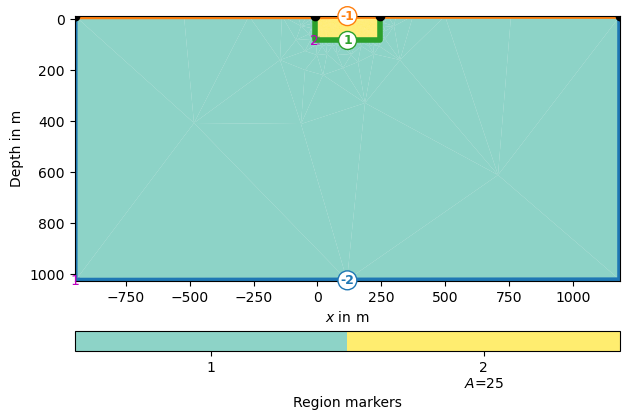

In [7]:
plc = mt.createParaMeshPLC(data,paraDX = 0.25, paraDZ= 0.25, paraMaxCellSize=25)
for i, n in enumerate(plc.nodes()[:]):
    #ax.text(n.x(), n.y(), str(i))
    print(i, n.x(), n.y(), n.z())
for nr, marker in enumerate(plc.regionMarkers()):
    print('Position marker number {}:'.format(nr + 1), marker.x(), marker.y(),
          marker.z())
ax, _ = pg.show(plc, markers=True)
mesh = mt.createMesh(plc)

10/11/25 - 09:06:37 - pyGIMLi - INFO - Saving inversion results to: //smb.isipd.dmawi.de/projects/p_subaqua/Expeditions/2023/NWT2023/analysis_Tuk/Tuk_all_mehriban/pygimli/all_inversions/ERTManager_western_perpendicular_updated/ERTManager


('//smb.isipd.dmawi.de/projects/p_subaqua/Expeditions/2023/NWT2023/analysis_Tuk/Tuk_all_mehriban/pygimli/all_inversions/ERTManager_western_perpendicular_updated/ERTManager',
 <Figure size 1600x1000 with 2 Axes>,
 <Axes: xlabel='$x$ in m', ylabel='Depth in m'>)

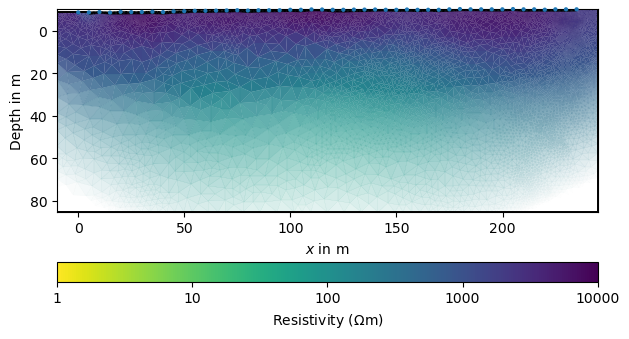

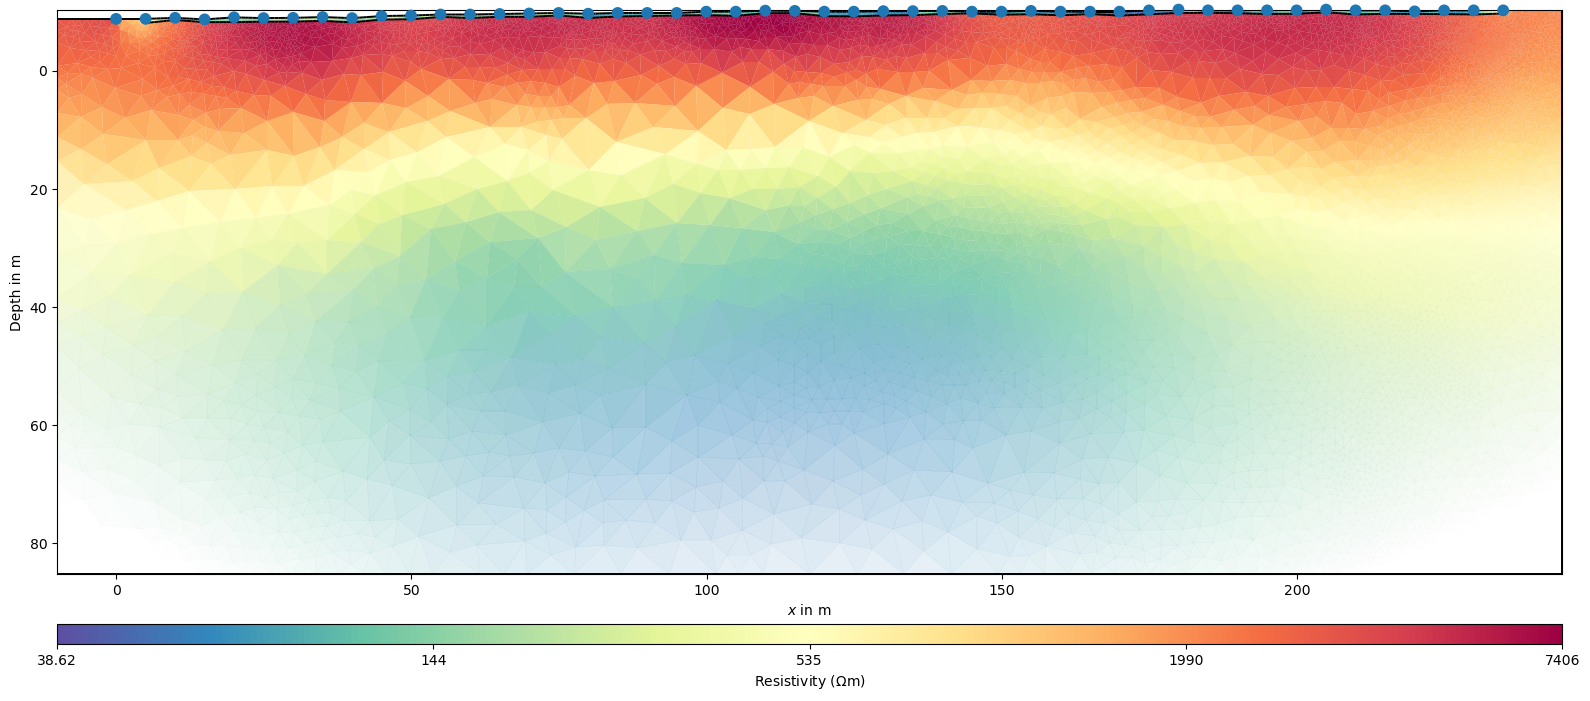

In [26]:
mgr.showResult(cMap="viridis_r", logScale=True, cMin=1, cMax=10000)
mgr.saveResult(dir+ 'pygimli/all_inversions/ERTManager_western_perpendicular_updated/')

21/02/25 - 09:46:31 - pyGIMLi - INFO - Use median(data values)=1304.2185056287365
21/02/25 - 09:46:31 - pyGIMLi - INFO - Created startmodel from forward operator: 1098, min/max=1304.218506/1304.218506
21/02/25 - 09:46:31 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x000001A3A815EA20>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x000001A3A81634C0>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x000001A3B3F61770>
min/max (data): 325/3356
min/max (error): 2%/37%
min/max (start model): 1304/1304
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =  151.91
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   36.40 (dPhi = 61.59%) lam: 1000.0
--------------------------------------------------------------------------------
inv.iter 2 ... 

21/02/25 - 09:47:28 - pyGIMLi - INFO - Use median(data values)=1304.2185056287365
21/02/25 - 09:47:28 - pyGIMLi - INFO - Created startmodel from forward operator: 1098, min/max=1304.218506/1304.218506
21/02/25 - 09:47:28 - pyGIMLi - INFO - Starting inversion.


chi² =   36.68 (dPhi = 4.97%) lam: 1000.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =   36.37 (dPhi = 0.19%) lam: 1000.0
################################################################################
#                Abort criterion reached: dPhi = 0.19 (< 2.0%)                 #
################################################################################
fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x000001A3A815EA20>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x000001A3A81634C0>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x000001A3B3F61700>
min/max (data): 325/3356
min/max (error): 2%/37%
min/max (start model): 1304/1304
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =  151.91
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   32.94 (dPhi = 64.

21/02/25 - 09:47:55 - pyGIMLi - INFO - Use median(data values)=1304.2185056287365
21/02/25 - 09:47:55 - pyGIMLi - INFO - Created startmodel from forward operator: 1098, min/max=1304.218506/1304.218506
21/02/25 - 09:47:55 - pyGIMLi - INFO - Starting inversion.


chi² =   32.55 (dPhi = 0.32%) lam: 799.9
################################################################################
#                Abort criterion reached: dPhi = 0.32 (< 2.0%)                 #
################################################################################
fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x000001A3A815EA20>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x000001A3A81634C0>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x000001A3B3F61700>
min/max (data): 325/3356
min/max (error): 2%/37%
min/max (start model): 1304/1304
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =  151.91
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   31.42 (dPhi = 67.02%) lam: 639.9
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =   30.13 (dPhi = 6.69

21/02/25 - 09:48:21 - pyGIMLi - INFO - Use median(data values)=1304.2185056287365
21/02/25 - 09:48:21 - pyGIMLi - INFO - Created startmodel from forward operator: 1098, min/max=1304.218506/1304.218506
21/02/25 - 09:48:21 - pyGIMLi - INFO - Starting inversion.


chi² =   28.96 (dPhi = 0.50%) lam: 639.9
################################################################################
#                 Abort criterion reached: dPhi = 0.5 (< 2.0%)                 #
################################################################################
fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x000001A3A815EA20>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x000001A3A81634C0>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x000001A3B3F61700>
min/max (data): 325/3356
min/max (error): 2%/37%
min/max (start model): 1304/1304
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =  151.91
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   28.47 (dPhi = 69.32%) lam: 511.9
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =   27.19 (dPhi = 8.32

21/02/25 - 09:48:49 - pyGIMLi - INFO - Use median(data values)=1304.2185056287365
21/02/25 - 09:48:49 - pyGIMLi - INFO - Created startmodel from forward operator: 1098, min/max=1304.218506/1304.218506
21/02/25 - 09:48:49 - pyGIMLi - INFO - Starting inversion.


chi² =   25.60 (dPhi = 0.77%) lam: 511.9
################################################################################
#                Abort criterion reached: dPhi = 0.77 (< 2.0%)                 #
################################################################################
fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x000001A3A815EA20>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x000001A3A81634C0>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x000001A3B3F61700>
min/max (data): 325/3356
min/max (error): 2%/37%
min/max (start model): 1304/1304
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =  151.91
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   26.20 (dPhi = 71.50%) lam: 409.5
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =   24.56 (dPhi = 10.0

21/02/25 - 09:49:24 - pyGIMLi - INFO - Use median(data values)=1304.2185056287365
21/02/25 - 09:49:24 - pyGIMLi - INFO - Created startmodel from forward operator: 1098, min/max=1304.218506/1304.218506
21/02/25 - 09:49:24 - pyGIMLi - INFO - Starting inversion.


chi² =   22.46 (dPhi = 1.17%) lam: 409.5
################################################################################
#                Abort criterion reached: dPhi = 1.17 (< 2.0%)                 #
################################################################################
fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x000001A3A815EA20>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x000001A3A81634C0>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x000001A3B3F61000>
min/max (data): 325/3356
min/max (error): 2%/37%
min/max (start model): 1304/1304
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =  151.91
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   23.84 (dPhi = 73.35%) lam: 327.6
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =   22.24 (dPhi = 12.3

21/02/25 - 09:49:49 - pyGIMLi - INFO - Use median(data values)=1304.2185056287365
21/02/25 - 09:49:49 - pyGIMLi - INFO - Created startmodel from forward operator: 1098, min/max=1304.218506/1304.218506
21/02/25 - 09:49:49 - pyGIMLi - INFO - Starting inversion.


chi² =   19.53 (dPhi = 1.85%) lam: 327.6
################################################################################
#                Abort criterion reached: dPhi = 1.85 (< 2.0%)                 #
################################################################################
fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x000001A3A815EA20>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x000001A3A81634C0>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x000001A3B3F63CA0>
min/max (data): 325/3356
min/max (error): 2%/37%
min/max (start model): 1304/1304
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =  151.91
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   22.20 (dPhi = 75.08%) lam: 262.0
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =   20.18 (dPhi = 14.7

21/02/25 - 09:50:18 - pyGIMLi - INFO - Use median(data values)=1304.2185056287365
21/02/25 - 09:50:18 - pyGIMLi - INFO - Created startmodel from forward operator: 1098, min/max=1304.218506/1304.218506
21/02/25 - 09:50:18 - pyGIMLi - INFO - Starting inversion.


chi² =   16.96 (dPhi = 0.03%) lam: 262.0
################################################################################
#                Abort criterion reached: dPhi = 0.03 (< 2.0%)                 #
################################################################################
fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x000001A3A815EA20>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x000001A3A81634C0>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x000001A3B3F61770>
min/max (data): 325/3356
min/max (error): 2%/37%
min/max (start model): 1304/1304
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =  151.91
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   20.72 (dPhi = 75.52%) lam: 209.6
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =   18.82 (dPhi = 19.9

21/02/25 - 09:50:51 - pyGIMLi - INFO - Use median(data values)=1304.2185056287365
21/02/25 - 09:50:51 - pyGIMLi - INFO - Created startmodel from forward operator: 1098, min/max=1304.218506/1304.218506
21/02/25 - 09:50:51 - pyGIMLi - INFO - Starting inversion.


chi² =   14.44 (dPhi = 5.37%) lam: 209.6
--------------------------------------------------------------------------------
inv.iter 4 ... chi² =   14.71 (dPhi = 0.12%) lam: 209.6
################################################################################
#                Abort criterion reached: dPhi = 0.12 (< 2.0%)                 #
################################################################################
fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x000001A3A815EA20>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x000001A3A81634C0>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x000001A3B3F61620>
min/max (data): 325/3356
min/max (error): 2%/37%
min/max (start model): 1304/1304
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =  151.91
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   20.29 (dPhi = 76.71

21/02/25 - 09:51:21 - pyGIMLi - INFO - Use median(data values)=1304.2185056287365
21/02/25 - 09:51:21 - pyGIMLi - INFO - Created startmodel from forward operator: 1098, min/max=1304.218506/1304.218506
21/02/25 - 09:51:21 - pyGIMLi - INFO - Starting inversion.


chi² =   12.58 (dPhi = 0.29%) lam: 167.7
################################################################################
#                Abort criterion reached: dPhi = 0.29 (< 2.0%)                 #
################################################################################
fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x000001A3A815EA20>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x000001A3A81634C0>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x000001A3B3F61000>
min/max (data): 325/3356
min/max (error): 2%/37%
min/max (start model): 1304/1304
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =  151.91
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   20.36 (dPhi = 77.61%) lam: 134.1
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =   16.44 (dPhi = 25.9

21/02/25 - 09:51:53 - pyGIMLi - INFO - Use median(data values)=1304.2185056287365
21/02/25 - 09:51:53 - pyGIMLi - INFO - Created startmodel from forward operator: 1098, min/max=1304.218506/1304.218506
21/02/25 - 09:51:53 - pyGIMLi - INFO - Starting inversion.


chi² =   10.22 (dPhi = 10.72%) lam: 134.1
--------------------------------------------------------------------------------
inv.iter 4 ... chi² =   10.68 (dPhi = 0.60%) lam: 134.1
################################################################################
#                 Abort criterion reached: dPhi = 0.6 (< 2.0%)                 #
################################################################################
fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x000001A3A815EA20>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x000001A3A81634C0>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x000001A3B3F618C0>
min/max (data): 325/3356
min/max (error): 2%/37%
min/max (start model): 1304/1304
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =  151.91
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   20.91 (dPhi = 78.2

21/02/25 - 09:52:25 - pyGIMLi - INFO - Use median(data values)=1304.2185056287365
21/02/25 - 09:52:25 - pyGIMLi - INFO - Created startmodel from forward operator: 1098, min/max=1304.218506/1304.218506
21/02/25 - 09:52:25 - pyGIMLi - INFO - Starting inversion.


chi² =    9.06 (dPhi = 1.14%) lam: 107.3
################################################################################
#                Abort criterion reached: dPhi = 1.14 (< 2.0%)                 #
################################################################################
fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x000001A3A815EA20>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x000001A3A81634C0>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x000001A3B3F63CA0>
min/max (data): 325/3356
min/max (error): 2%/37%
min/max (start model): 1304/1304
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =  151.91
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   21.89 (dPhi = 78.53%) lam: 85.8
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =   14.86 (dPhi = 33.26

21/02/25 - 09:52:56 - pyGIMLi - INFO - Use median(data values)=1304.2185056287365
21/02/25 - 09:52:56 - pyGIMLi - INFO - Created startmodel from forward operator: 1098, min/max=1304.218506/1304.218506
21/02/25 - 09:52:56 - pyGIMLi - INFO - Starting inversion.


chi² =    7.48 (dPhi = 16.74%) lam: 85.8
--------------------------------------------------------------------------------
inv.iter 4 ... chi² =    7.82 (dPhi = 1.96%) lam: 85.8
################################################################################
#                Abort criterion reached: dPhi = 1.96 (< 2.0%)                 #
################################################################################
fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x000001A3A815EA20>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x000001A3A81634C0>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x000001A3B3F61700>
min/max (data): 325/3356
min/max (error): 2%/37%
min/max (start model): 1304/1304
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =  151.91
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   23.21 (dPhi = 78.56%

21/02/25 - 09:53:37 - pyGIMLi - INFO - Use median(data values)=1304.2185056287365
21/02/25 - 09:53:37 - pyGIMLi - INFO - Created startmodel from forward operator: 1098, min/max=1304.218506/1304.218506
21/02/25 - 09:53:37 - pyGIMLi - INFO - Starting inversion.


chi² =    6.23 (dPhi = 1.65%) lam: 68.7
################################################################################
#                Abort criterion reached: dPhi = 1.65 (< 2.0%)                 #
################################################################################
fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x000001A3A815EA20>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x000001A3A81634C0>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x000001A3B3F61700>
min/max (data): 325/3356
min/max (error): 2%/37%
min/max (start model): 1304/1304
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =  151.91
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   24.80 (dPhi = 78.36%) lam: 54.9
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =   13.01 (dPhi = 42.79%

21/02/25 - 09:54:26 - pyGIMLi - INFO - Use median(data values)=1304.2185056287365
21/02/25 - 09:54:26 - pyGIMLi - INFO - Created startmodel from forward operator: 1098, min/max=1304.218506/1304.218506
21/02/25 - 09:54:26 - pyGIMLi - INFO - Starting inversion.


chi² =    5.35 (dPhi = 2.20%) lam: 54.9
--------------------------------------------------------------------------------
inv.iter 7 ... chi² =    5.39 (dPhi = 0.07%) lam: 54.9
################################################################################
#                Abort criterion reached: dPhi = 0.07 (< 2.0%)                 #
################################################################################
fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x000001A3A815EA20>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x000001A3A81634C0>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x000001A3B3F615B0>
min/max (data): 325/3356
min/max (error): 2%/37%
min/max (start model): 1304/1304
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =  151.91
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   26.55 (dPhi = 77.98%)

21/02/25 - 09:55:55 - pyGIMLi - INFO - Use median(data values)=1304.2185056287365
21/02/25 - 09:55:55 - pyGIMLi - INFO - Created startmodel from forward operator: 1098, min/max=1304.218506/1304.218506
21/02/25 - 09:55:55 - pyGIMLi - INFO - Starting inversion.


chi² =    4.63 (dPhi = 0.09%) lam: 43.9
################################################################################
#                Abort criterion reached: dPhi = 0.09 (< 2.0%)                 #
################################################################################
fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x000001A3A815EA20>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x000001A3A81634C0>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x000001A3B3F61700>
min/max (data): 325/3356
min/max (error): 2%/37%
min/max (start model): 1304/1304
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =  151.91
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   28.36 (dPhi = 77.47%) lam: 35.1
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =    9.67 (dPhi = 57.01%

21/02/25 - 09:59:10 - pyGIMLi - INFO - Use median(data values)=1304.2185056287365
21/02/25 - 09:59:10 - pyGIMLi - INFO - Created startmodel from forward operator: 1098, min/max=1304.218506/1304.218506
21/02/25 - 09:59:10 - pyGIMLi - INFO - Starting inversion.


chi² =    4.14 (dPhi = 0.56%) lam: 35.1
################################################################################
#                Abort criterion reached: dPhi = 0.56 (< 2.0%)                 #
################################################################################
fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x000001A3A815EA20>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x000001A3A81634C0>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x000001A3B3F61700>
min/max (data): 325/3356
min/max (error): 2%/37%
min/max (start model): 1304/1304
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =  151.91
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   30.15 (dPhi = 76.89%) lam: 28.1
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =    8.33 (dPhi = 62.89%

21/02/25 - 10:01:08 - pyGIMLi - INFO - Use median(data values)=1304.2185056287365
21/02/25 - 10:01:08 - pyGIMLi - INFO - Created startmodel from forward operator: 1098, min/max=1304.218506/1304.218506
21/02/25 - 10:01:08 - pyGIMLi - INFO - Starting inversion.


chi² =    4.44 (dPhi = 1.25%) lam: 28.1
################################################################################
#                Abort criterion reached: dPhi = 1.25 (< 2.0%)                 #
################################################################################
fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x000001A3A815EA20>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x000001A3A81634C0>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x000001A3B3F618C0>
min/max (data): 325/3356
min/max (error): 2%/37%
min/max (start model): 1304/1304
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =  151.91
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   31.87 (dPhi = 76.28%) lam: 22.5
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =    7.43 (dPhi = 67.27%

21/02/25 - 10:02:08 - pyGIMLi - INFO - Use median(data values)=1304.2185056287365
21/02/25 - 10:02:08 - pyGIMLi - INFO - Created startmodel from forward operator: 1098, min/max=1304.218506/1304.218506
21/02/25 - 10:02:08 - pyGIMLi - INFO - Starting inversion.


chi² =    3.73 (dPhi = 4.42%) lam: 22.5
--------------------------------------------------------------------------------
inv.iter 5 ... chi² =    3.22 (dPhi = 5.52%) lam: 22.5
--------------------------------------------------------------------------------
inv.iter 6 ... chi² =    3.06 (dPhi = 0.35%) lam: 22.5
################################################################################
#                Abort criterion reached: dPhi = 0.35 (< 2.0%)                 #
################################################################################
fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x000001A3A815EA20>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x000001A3A81634C0>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x000001A3B3F63CA0>
min/max (data): 325/3356
min/max (error): 2%/37%
min/max (start model): 1304/1304
--------------------------------------------------------------------------------
inv.iter 0 ... chi² 

21/02/25 - 10:03:51 - pyGIMLi - INFO - Use median(data values)=1304.2185056287365
21/02/25 - 10:03:51 - pyGIMLi - INFO - Created startmodel from forward operator: 1098, min/max=1304.218506/1304.218506
21/02/25 - 10:03:51 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x000001A3A815EA20>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x000001A3A81634C0>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x000001A3B3F61A80>
min/max (data): 325/3356
min/max (error): 2%/37%
min/max (start model): 1304/1304
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =  151.91
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   34.91 (dPhi = 75.10%) lam: 14.4
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =    7.66 (dPhi = 70.04%) lam: 14.4
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =    2.56 (dPhi = 44.70%) lam: 14.4
--------------------------------------------------------------------------------
inv.iter 4 ... 

21/02/25 - 10:06:19 - pyGIMLi - INFO - Use median(data values)=1304.2185056287365
21/02/25 - 10:06:19 - pyGIMLi - INFO - Created startmodel from forward operator: 1098, min/max=1304.218506/1304.218506
21/02/25 - 10:06:19 - pyGIMLi - INFO - Starting inversion.


chi² =    2.57 (dPhi = 1.89%) lam: 14.4
################################################################################
#                Abort criterion reached: dPhi = 1.89 (< 2.0%)                 #
################################################################################
fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x000001A3A815EA20>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x000001A3A81634C0>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x000001A3B3F61690>
min/max (data): 325/3356
min/max (error): 2%/37%
min/max (start model): 1304/1304
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =  151.91
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   36.23 (dPhi = 74.55%) lam: 11.5
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =    9.20 (dPhi = 67.60%

21/02/25 - 10:08:23 - pyGIMLi - INFO - Use median(data values)=1304.2185056287365
21/02/25 - 10:08:23 - pyGIMLi - INFO - Created startmodel from forward operator: 1098, min/max=1304.218506/1304.218506
21/02/25 - 10:08:23 - pyGIMLi - INFO - Starting inversion.


chi² =    2.17 (dPhi = 1.25%) lam: 11.5
################################################################################
#                Abort criterion reached: dPhi = 1.25 (< 2.0%)                 #
################################################################################
fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x000001A3A815EA20>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x000001A3A81634C0>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x000001A3B3F61690>
min/max (data): 325/3356
min/max (error): 2%/37%
min/max (start model): 1304/1304
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =  151.91
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   37.40 (dPhi = 74.04%) lam: 9.2
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =   11.97 (dPhi = 62.08%)

21/02/25 - 10:09:23 - pyGIMLi - INFO - Use median(data values)=1304.2185056287365
21/02/25 - 10:09:23 - pyGIMLi - INFO - Created startmodel from forward operator: 1098, min/max=1304.218506/1304.218506
21/02/25 - 10:09:23 - pyGIMLi - INFO - Starting inversion.


chi² =    1.89 (dPhi = 1.07%) lam: 9.2
################################################################################
#                Abort criterion reached: dPhi = 1.07 (< 2.0%)                 #
################################################################################
fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x000001A3A815EA20>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x000001A3A81634C0>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x000001A3B3F61690>
min/max (data): 325/3356
min/max (error): 2%/37%
min/max (start model): 1304/1304
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =  151.91
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   38.54 (dPhi = 73.52%) lam: 7.4
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =   16.08 (dPhi = 53.48%) 

21/02/25 - 10:10:14 - pyGIMLi - INFO - Use median(data values)=1304.2185056287365
21/02/25 - 10:10:14 - pyGIMLi - INFO - Created startmodel from forward operator: 1098, min/max=1304.218506/1304.218506
21/02/25 - 10:10:14 - pyGIMLi - INFO - Starting inversion.


chi² =    1.63 (dPhi = 2.33%) lam: 7.4
--------------------------------------------------------------------------------
inv.iter 5 ... chi² =    1.51 (dPhi = 0.59%) lam: 7.4
################################################################################
#                Abort criterion reached: dPhi = 0.59 (< 2.0%)                 #
################################################################################
fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x000001A3A815EA20>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x000001A3A81634C0>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x000001A3B3F61770>
min/max (data): 325/3356
min/max (error): 2%/37%
min/max (start model): 1304/1304
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =  151.91
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   39.57 (dPhi = 73.02%) l

21/02/25 - 10:11:52 - pyGIMLi - INFO - Use median(data values)=1304.2185056287365
21/02/25 - 10:11:52 - pyGIMLi - INFO - Created startmodel from forward operator: 1098, min/max=1304.218506/1304.218506
21/02/25 - 10:11:52 - pyGIMLi - INFO - Starting inversion.


chi² =    1.37 (dPhi = 1.90%) lam: 5.9
################################################################################
#                 Abort criterion reached: dPhi = 1.9 (< 2.0%)                 #
################################################################################
fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x000001A3A815EA20>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x000001A3A81634C0>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x000001A3B3F61700>
min/max (data): 325/3356
min/max (error): 2%/37%
min/max (start model): 1304/1304
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =  151.91
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   40.56 (dPhi = 72.52%) lam: 4.7
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =   18.74 (dPhi = 51.16%) 

21/02/25 - 10:17:13 - pyGIMLi - INFO - Use median(data values)=1304.2185056287365
21/02/25 - 10:17:13 - pyGIMLi - INFO - Created startmodel from forward operator: 1098, min/max=1304.218506/1304.218506
21/02/25 - 10:17:13 - pyGIMLi - INFO - Starting inversion.


chi² =    1.15 (dPhi = 1.69%) lam: 4.7
################################################################################
#                Abort criterion reached: dPhi = 1.69 (< 2.0%)                 #
################################################################################
fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x000001A3A815EA20>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x000001A3A81634C0>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x000001A3B3F61700>
min/max (data): 325/3356
min/max (error): 2%/37%
min/max (start model): 1304/1304
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =  151.91
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   41.59 (dPhi = 71.97%) lam: 3.8
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =   19.10 (dPhi = 52.24%) 

21/02/25 - 10:19:31 - pyGIMLi - INFO - Use median(data values)=1304.2185056287365
21/02/25 - 10:19:31 - pyGIMLi - INFO - Created startmodel from forward operator: 1098, min/max=1304.218506/1304.218506
21/02/25 - 10:19:31 - pyGIMLi - INFO - Starting inversion.


chi² =    1.03 (dPhi = 0.90%) lam: 3.8
################################################################################
#                 Abort criterion reached: dPhi = 0.9 (< 2.0%)                 #
################################################################################
fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x000001A3A815EA20>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x000001A3A81634C0>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x000001A3B3F61070>
min/max (data): 325/3356
min/max (error): 2%/37%
min/max (start model): 1304/1304
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =  151.91
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   42.62 (dPhi = 71.39%) lam: 3.0
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =   20.89 (dPhi = 49.76%) 

21/02/25 - 10:21:04 - pyGIMLi - INFO - Use median(data values)=1304.2185056287365
21/02/25 - 10:21:04 - pyGIMLi - INFO - Created startmodel from forward operator: 1098, min/max=1304.218506/1304.218506
21/02/25 - 10:21:04 - pyGIMLi - INFO - Starting inversion.


chi² =    0.82 (dPhi = 16.23%) lam: 3.0


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.82)                   #
################################################################################
fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x000001A3A815EA20>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x000001A3A81634C0>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x000001A3B3F61700>
min/max (data): 325/3356
min/max (error): 2%/37%
min/max (start model): 1304/1304
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =  151.91
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   43.78 (dPhi = 70.72%) lam: 2.4
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =   23.54 (dPhi = 45.42

21/02/25 - 10:24:27 - pyGIMLi - INFO - Use median(data values)=1304.2185056287365
21/02/25 - 10:24:27 - pyGIMLi - INFO - Created startmodel from forward operator: 1098, min/max=1304.218506/1304.218506
21/02/25 - 10:24:27 - pyGIMLi - INFO - Starting inversion.


chi² =    1.00 (dPhi = 5.09%) lam: 2.4


################################################################################
#                  Abort criterion reached: chi² <= 1 (1.00)                   #
################################################################################
fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x000001A3A815EA20>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x000001A3A81634C0>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x000001A3B3F61700>
min/max (data): 325/3356
min/max (error): 2%/37%
min/max (start model): 1304/1304
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =  151.91
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   44.96 (dPhi = 70.01%) lam: 1.9
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =   26.63 (dPhi = 40.22%

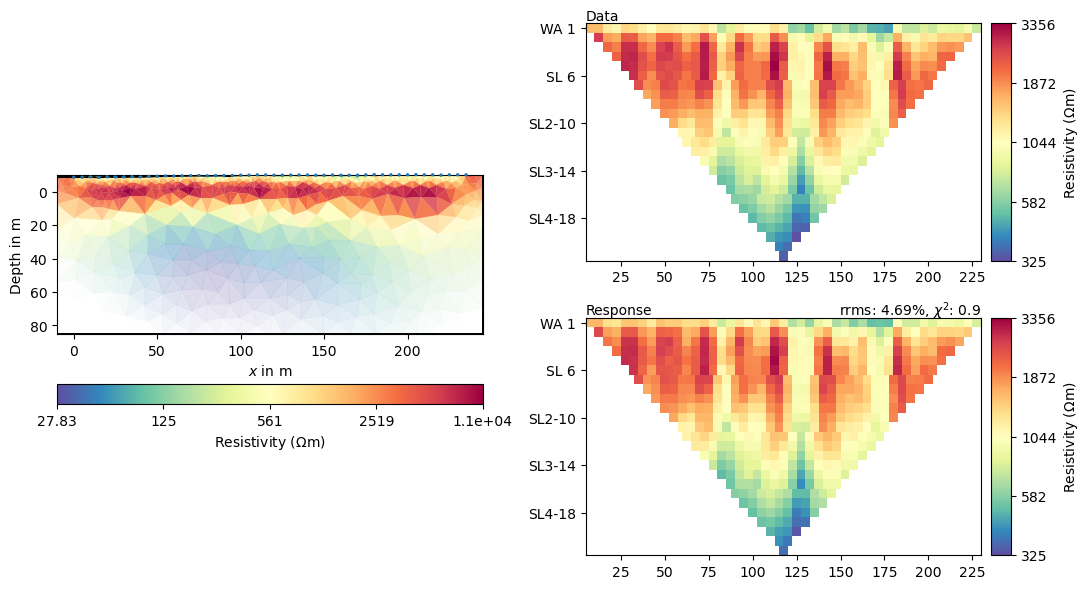

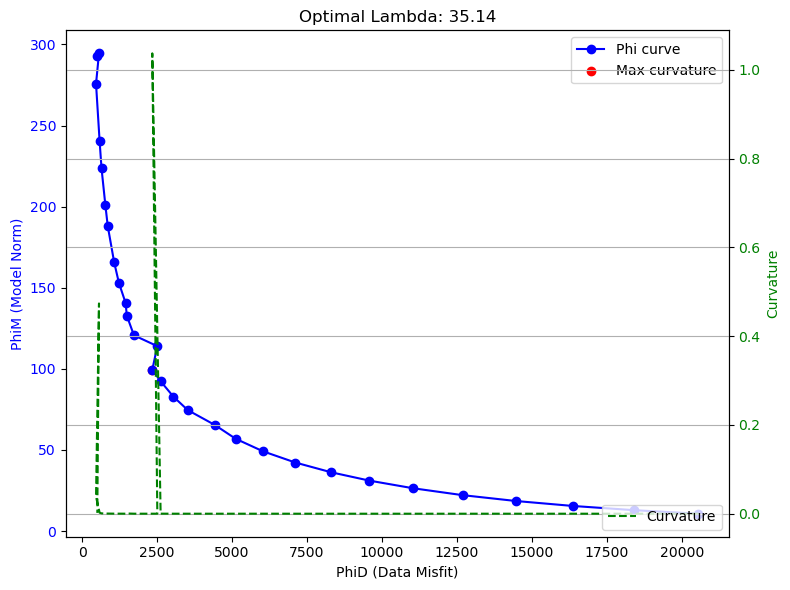

In [119]:

lambdas = np.logspace(np.log10(1000), np.log10(1.93), num=29)

phiD = []
phiM = []
for lam in lambdas:
    mgr.invert(data, lam=lam, verbose=True)
    phiD.append(mgr.inv.phiData())
    phiM.append(mgr.inv.phiModel())


mgr.showResultAndFit()

phiD = np.array(phiD)
phiM = np.array(phiM)
dphiD = np.gradient(phiD, lambdas)  # First derivative of phiD w.r.t. lambdas
dphiM = np.gradient(phiM, lambdas)  # First derivative of phiM w.r.t. lambdas
ddphiD = np.gradient(dphiD, lambdas)  # Second derivative of phiD
ddphiM = np.gradient(dphiM, lambdas)  # Second derivative of phiM

# Compute curvature
curvature = np.abs(dphiD * ddphiM - dphiM * ddphiD) / (dphiD**2 + dphiM**2)**1.5

# Find maximum curvature
max_curvature_index = np.argmax(curvature)
optimal_lambda = lambdas[max_curvature_index]

# Plot Phi curve and curvature
fig, ax1 = plt.subplots(figsize=(8, 6))

# Plot Phi curve
ax1.plot(phiD, phiM, '-o', label='Phi curve', color='blue')
ax1.scatter(phiD[max_curvature_index], phiM[max_curvature_index], color='red', label='Max curvature')
ax1.set_xlabel('PhiD (Data Misfit)')
ax1.set_ylabel('PhiM (Model Norm)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.legend(loc='upper right')

# Add curvature plot on secondary axis
ax2 = ax1.twinx()
ax2.plot(phiD, curvature, '--', label='Curvature', color='green')
ax2.set_ylabel('Curvature', color='green')
ax2.tick_params(axis='y', labelcolor='green')
ax2.legend(loc='lower right')

plt.title(f'Optimal Lambda: {optimal_lambda:.2f}')
plt.grid()
plt.tight_layout()
plt.show()

140.58
1450.861
[14.38986586]


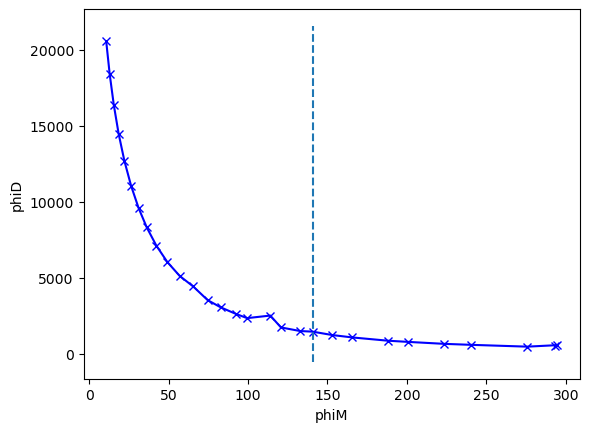

In [ ]:
from kneed import DataGenerator, KneeLocator
kneedle = KneeLocator(phiM, phiD, online=True, curve="convex", direction="decreasing",interp_method='polynomial', polynomial_degree=2)

print(round(kneedle.elbow, 3))
print(round(kneedle.elbow_y, 3))
print(lambdas[np.where(phiM==kneedle.elbow)[0]])

plt.xlabel('phiM')
plt.ylabel('phiD')
plt.plot(phiM, phiD, 'bx-')
plt.vlines(kneedle.elbow, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')


In [151]:
phiM_clean = np.delete(phiM, 16)
phiD_clean = np.delete(phiD, 16)
lambdas_clean = np.delete(lambdas, 16)

In [150]:
lambdas

array([1000.        ,  799.93669281,  639.89871251,  511.87845982,
        409.47036227,  327.5503674 ,  262.01955762,  209.59905838,
        167.66597758,  134.1221676 ,  107.28924318,   85.82460236,
         68.65424858,   54.91905255,   43.93176527,   35.14263102,
         28.11188004,   22.48772434,   17.98875584,   14.38986586,
         11.5109817 ,    9.20805663,    7.36586237,    5.89222358,
          4.71340585,    3.77042629,    3.01610233,    2.41269093,
          1.93      ])

99.415
2339.567
[35.14263102]


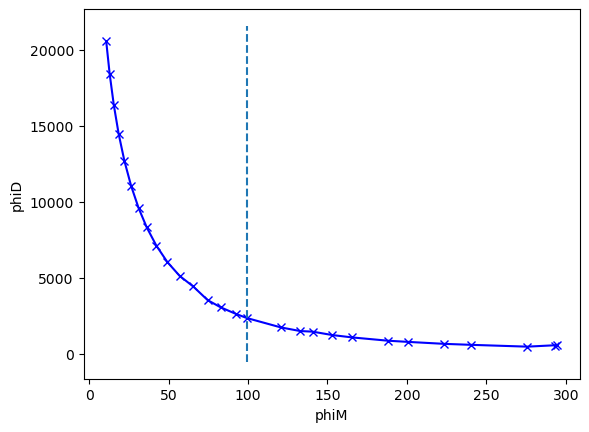

In [156]:
from kneed import DataGenerator, KneeLocator
kneedle = KneeLocator(phiM_clean, phiD_clean, online=True, curve="convex", direction="decreasing",interp_method='polynomial', polynomial_degree=3)

print(round(kneedle.elbow, 3))
print(round(kneedle.elbow_y, 3))
print(lambdas_clean[np.where(phiM_clean==kneedle.elbow)[0]])

plt.xlabel('phiM')
plt.ylabel('phiD')
plt.plot(phiM_clean, phiD_clean, 'bx-')
plt.vlines(kneedle.elbow, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')


11/05/25 - 20:56:28 - pyGIMLi - INFO - Found 2 regions.
11/05/25 - 20:56:28 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
11/05/25 - 20:56:28 - pyGIMLi - INFO - Creating forward mesh from region infos.
11/05/25 - 20:56:28 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
11/05/25 - 20:56:28 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 5607 Cells: 10848 Boundaries: 8318
11/05/25 - 20:56:28 - pyGIMLi - INFO - Use median(data values)=1304.2185056287365
11/05/25 - 20:56:28 - pyGIMLi - INFO - Created startmodel from forward operator:2135, min/max=1304.218506/1304.218506
11/05/25 - 20:56:28 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x000001897DE7FAB0>
Data transformation: Logarithmic LU transform, lower bound 0.0, upper bound 0.0
Model transformation: Logarithmic transform
min/max (data): 325/3356
min/max (error): 2%/37%
min/max (start model): 1304/1304
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =  151.92
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   28.20 (dPhi = 77.52%) lam: 35.0
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =   10.27 (dPhi = 55.02%) lam: 35.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =    5.54 (dPhi = 20.56%) lam: 35.0
--------------------------------------------------------------------------------
inv.iter 4 ... chi² =    5.31 (dPhi = 4.74%) lam: 35.0
------------------------------------------------------

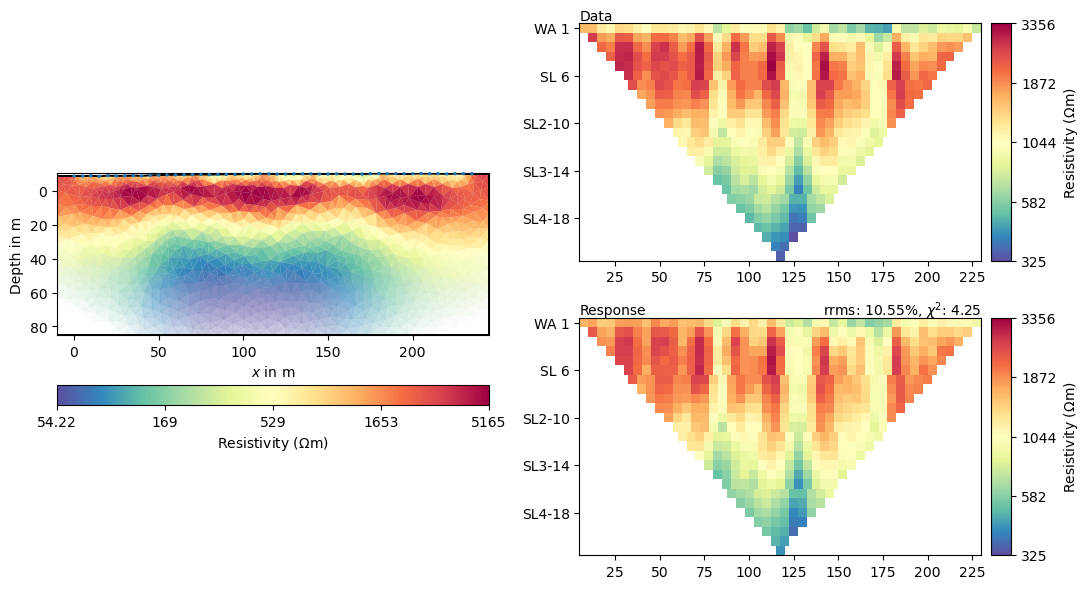

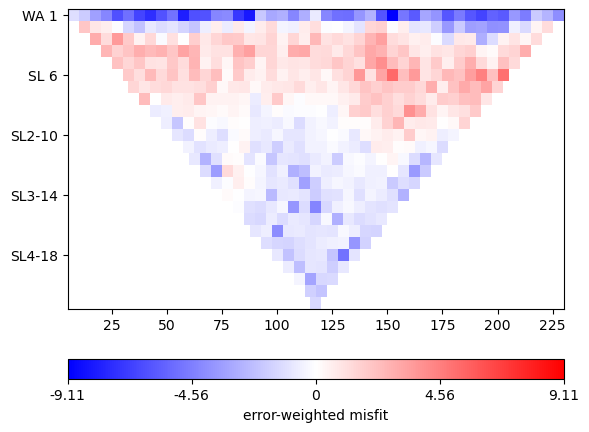

In [10]:
mgr.setMesh(mesh)


inv = mgr.invert(verbose=True, lam=35)


mgr.showResultAndFit()
mgr.showMisfit(errorWeighted=True)

Text(85.00003970187561, 0.5, 'y (m)')

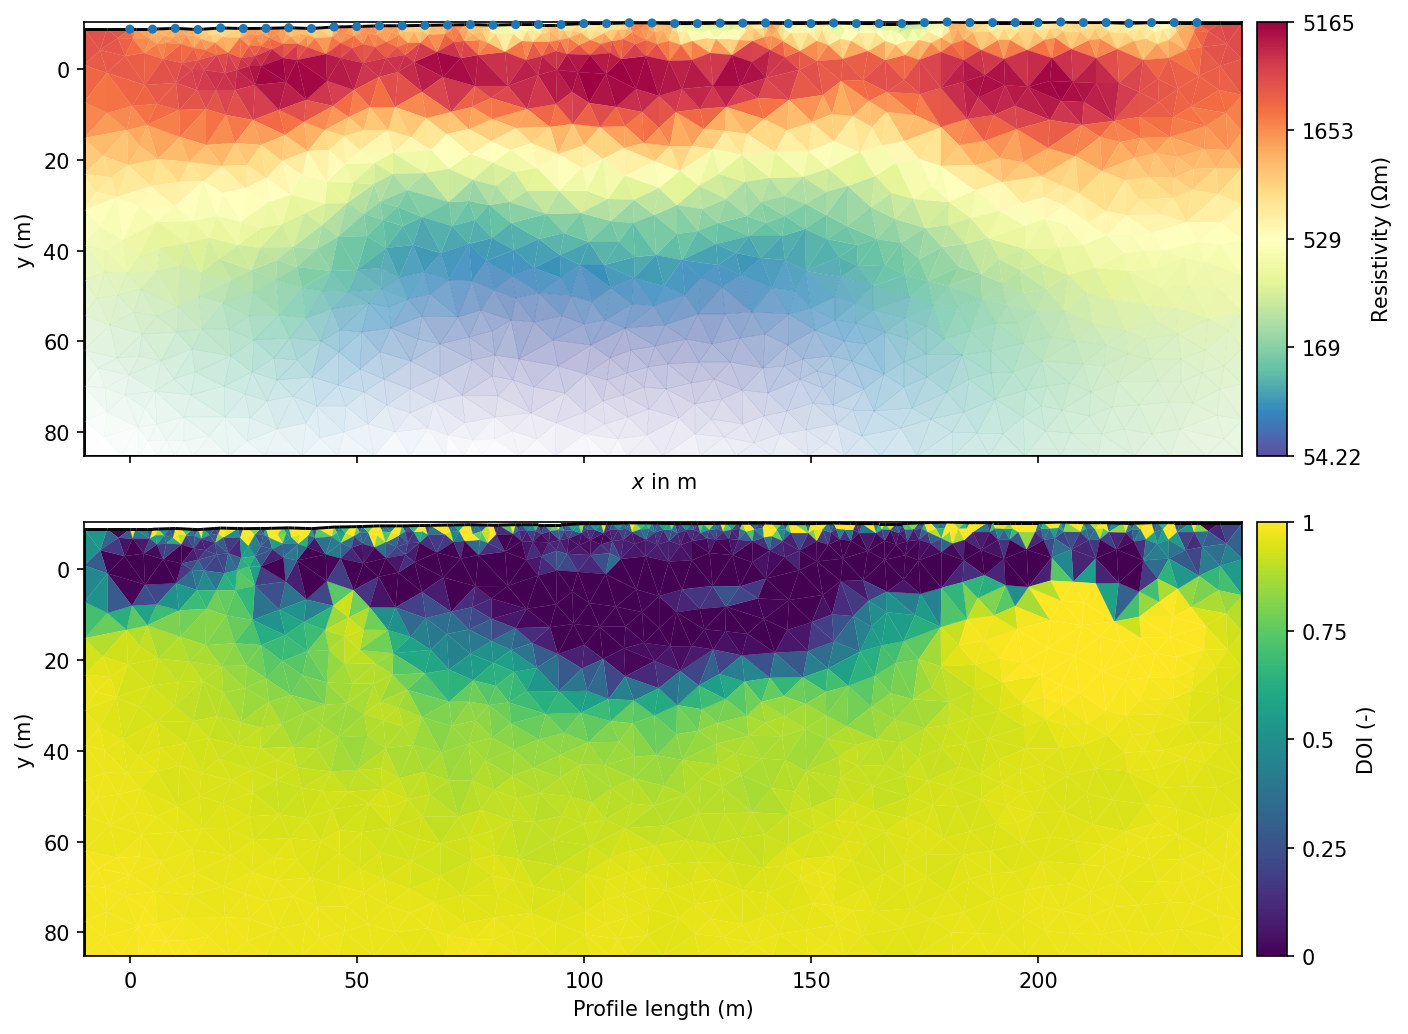

In [11]:

def run_inv(referencemodel):
    # Set reference model as startmodel
    mgr.inv.inv.setModel(referencemodel)

    # Set reference model
    rm = mgr.inv.fop.regionManager()
    rm.setConstraintType(10) # 0 = reference model, 1 = first-order smoothing (default), 10 = both
    rm.fillConstraints(mgr.inv.fop.constraints())
    mgr.inv.inv.setReferenceModel(referencemodel)
    model = mgr.inv.inv.run()
    return model

def compute_DOI(ref1, ref2):
    m1 = run_inv(ref1)
    m2 = run_inv(ref2)

    R = (m1 - m2) / (m1r - m2r)
    return R


m1r = np.ones(mgr.paraDomain.cellCount()) * 140
m2r = np.ones(mgr.paraDomain.cellCount()) * 14000

DOI = compute_DOI(m1r, m2r)

fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(10,7), dpi=150, sharex=True)

mgr.showResult(ax=ax1, orientation="vertical")
#ax1.set_xlabel("Profile length")
ax1.set_ylabel("y (m)")
pg.show(mgr.paraDomain, DOI, ax=ax2, cMin=0, cMax=1, orientation="vertical", label="DOI (-)")
ax2.set_xlabel("Profile length (m)")
ax2.set_ylabel("y (m)")

C:\Users\mealiy001\AppData\Local\Temp\ipykernel_40152\3554076232.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f"{tick:.1f}" for tick in relative_ticks])


Text(127.58333333333333, 0.5, 'Relative Elevation (m)')

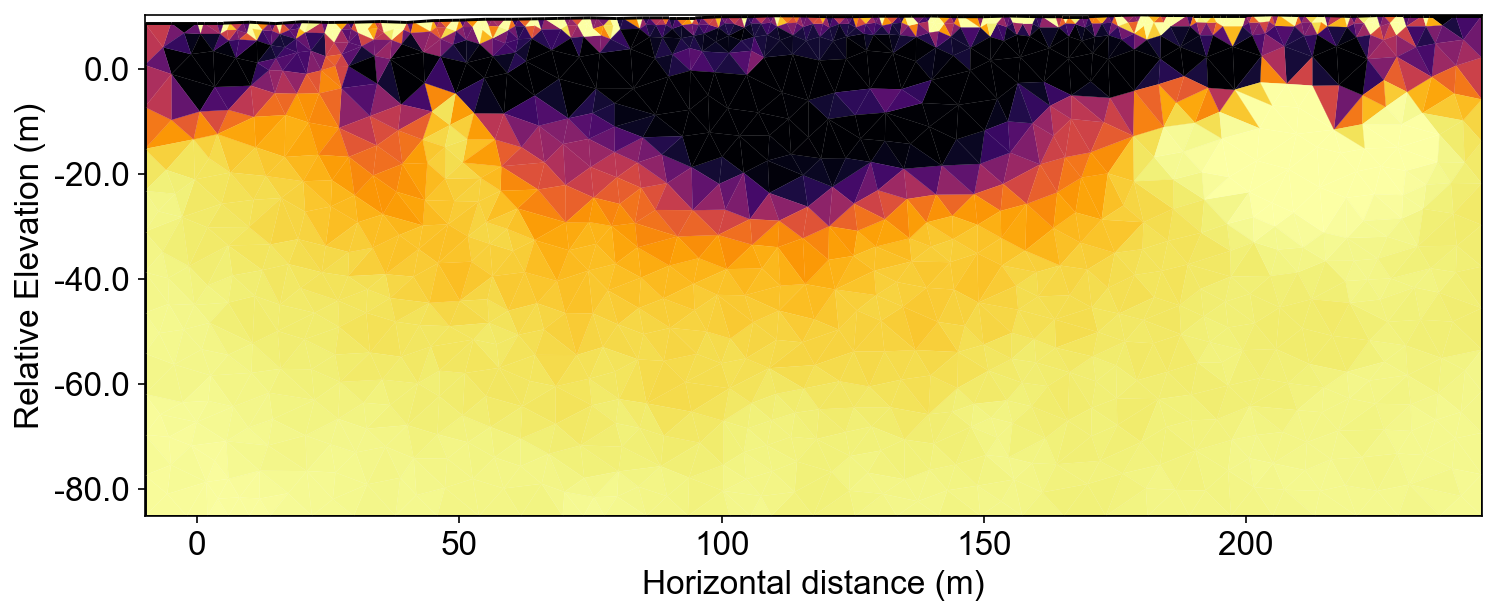

In [17]:
fig, (ax) = plt.subplots(1, 1, figsize=(10,5), dpi=150, sharex=True)
plt.rcParams['font.size'] = 16
plt.rcParams['font.family'] = 'Arial'
mgr.showResult(ax=ax1, orientation="vertical")
#ax1.set_xlabel("Profile length")
#ax1.set_ylabel("y (m)")
pg.show(mgr.paraDomain, DOI, ax=ax, cMin=0, cMax=1, orientation="vertical", label="DOI", cMap='inferno', colorBar=False)
ax.set_xlabel("Horizontal distance (m)")
ax.set_ylabel("y (m)")
current_ticks = ax.get_yticks()
relative_ticks = current_ticks   # Assuming 17 is the minimum elevation

# Set the new tick labels to show relative elevation

ax.set_yticklabels([f"{tick:.1f}" for tick in relative_ticks])
ax.set_ylabel("Relative Elevation (m)", fontsize=16)

In [20]:
mesh = mgr.paraDomain
mesh["DOI"] = DOI


mesh.exportVTK(dir+'pygimli/all_inversions/west_per_DOI.vtk')

Text(100.58333333333347, 0.5, 'y (m)')

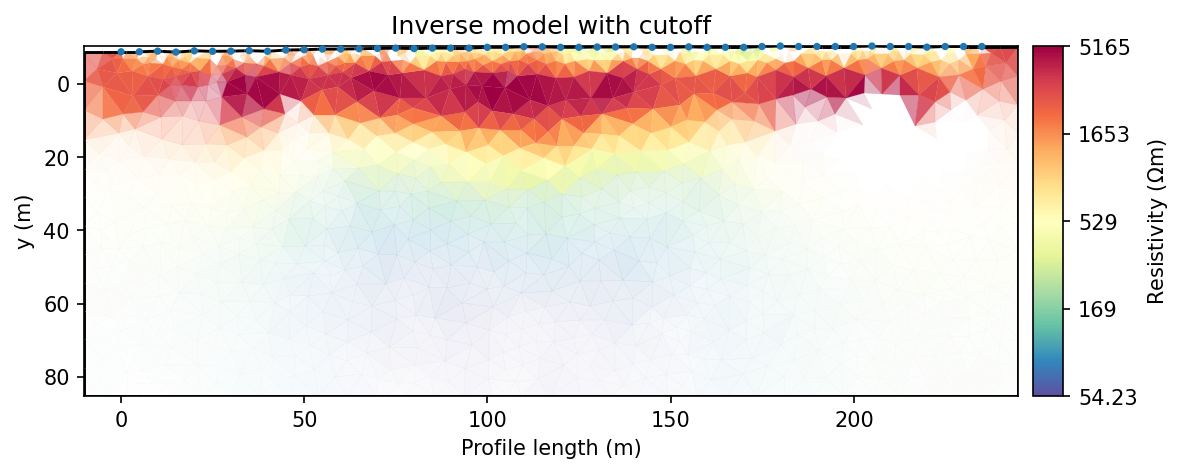

In [13]:
import numpy as np

def doi_to_transparency(doi, doiThreshold=0.2, maxDOI=1.0):
    """
    Convert DOI values into transparency values for visualization.

    Parameters:
        doi (array-like): DOI values.
        doiThreshold (float): DOI value below which transparency is 1 (fully opaque).
        maxDOI (float): DOI value at which transparency is 0 (fully transparent).

    Returns:
        array-like: Transparency values (1 = opaque, 0 = fully transparent).
    """
    D = np.asarray(doi)
    
    # Initialize alpha (transparency) array
    alpha = np.ones_like(D)  # Default to fully opaque

    # Apply gradual transparency beyond the DOI threshold
    mask = D > doiThreshold
    alpha[mask] = 1.0 - (D[mask] - doiThreshold) / (maxDOI - doiThreshold)

    # Cap values to ensure transparency is within [0,1]
    alpha = np.clip(alpha, 0, 1)
    
    return alpha



#opacity = np.ones(mgr.paraDomain.cellCount())
#opacity[DOI > 0.2] = 0
opacity = doi_to_transparency(DOI)
fig, ax = plt.subplots(1,1, figsize=(8,5), dpi=150)
mgr.showResult(ax=ax, coverage=opacity, orientation = "vertical")
ax.set_title("Inverse model with cutoff")
ax.set_xlabel("Profile length (m)")
ax.set_ylabel("y (m)")

Text(100.58333333333347, 0.5, 'y (m)')

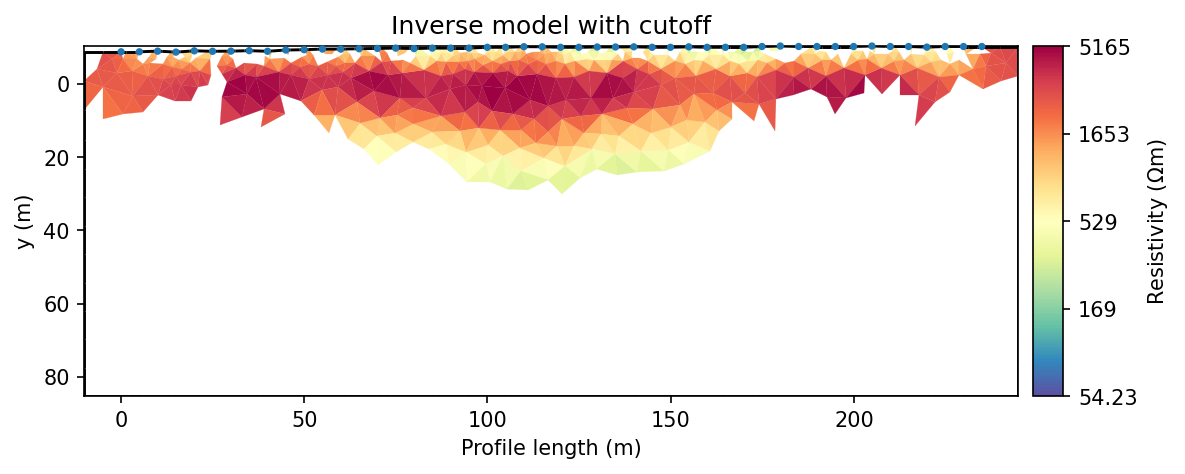

In [16]:
opacity = np.ones(mgr.paraDomain.cellCount())
opacity[DOI > 0.5] = 0
fig, ax = plt.subplots(1,1, figsize=(8,5), dpi=150)
mgr.showResult(ax=ax, coverage=opacity, orientation = "vertical")
ax.set_title("Inverse model with cutoff")
ax.set_xlabel("Profile length (m)")
ax.set_ylabel("y (m)")